# Inferential Analysis

### Feature selection

As discovered during EDA, there is high multicolinearity in our feature set. We'll reference the association heatmaps in the EDA notebook. 

To begin, we'll address the redundancy between 'Admission grade' and 'Previous qualification (grade)' by removing whichever one has lower mutual information with the target. 

In [1]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

X = pd.read_csv('LogReg/X.csv')
y = pd.read_csv('LogReg/y.csv')

y_np = y.to_numpy()
y_np = y_np.ravel()

ag = mutual_info_classif(X['Admission grade'].to_frame(), y_np, discrete_features=False, random_state=1)
pqg = mutual_info_classif(X['Previous qualification (grade)'].to_frame(), y_np, discrete_features=False, random_state=1)

print(f'Admission grade: {ag}\nPrevious qualification (grade): {pqg}')

Admission grade: [0.02852458]
Previous qualification (grade): [0.0357418]


We'll remove 'Admission grade'.

We'll also remove 'International' because it's completely redundant with 'Nationality' but provides less information.

Next, we'll address the fact that 'Course' and 'Daytime/evening attendance' are one for one associated. We'll remove 'Daytime/evening attendance' because it's redundant with 'Course', which contains more information.

Curricular units (enrolled), for both 1st and 2nd semesters, are highly associated with 'Course'. However, we should be careful about removing either since they provide very different types of information. Let's compare their relatinships to the target using mutual information. We can't compare VIF scores since one feature is categorical. 

In [2]:
# COMPARE MUTUAL INFORMATION
c = mutual_info_classif(X['Course'].to_frame(), y_np, discrete_features=True, random_state=1)
cu = mutual_info_classif(X['Curricular units 1st sem (enrolled)'].to_frame(), y_np, discrete_features=False, random_state=1)

print(f'Course: {c}\nCurricular units 1st sem (enrolled): {cu}')

Course: [0.03455513]
Curricular units 1st sem (enrolled): [0.02378636]


In [3]:
# REMOVE REDUNDANT FEATURES

X = X.drop(['Admission grade', 'Daytime/evening attendance', 'International'], axis=1)

It's still not clear if it's suitable to remove one or the other. Let's keep both for now and choose one based on model performance later.

Now we need to address the high multicolinearity among all the features measuring curricular units. Let's try using PCA.<br>
First, we'll try PCA using all the features. This probably won't yield good results as most of the features aren't correlated amongst each other. Then, we'll try using subset PCA, wherein only the curricular unit features are transformed and the other features are left unchanged.

In [4]:
from sklearn.decomposition import PCA

curr_units = [
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)'
]

# ALL FEATURES
pca_all = PCA(n_components=3)
pca_all.fit(X)

# CURR UNITS FEATURES
pca_cu = PCA(n_components=3)
pca_cu.fit(X[curr_units])

print(f'All features:\n{pca_all.explained_variance_ratio_}\n\nCurr Units features:\n{pca_cu.explained_variance_ratio_}')

All features:
[9.99840289e-01 7.80459674e-05 4.11694210e-05]

Curr Units features:
[0.64980168 0.25016538 0.05229662]


The components of pca_all explain almost no variance, whereas the first two components of pca_cu explain 90% of it. We'll replace all the curricular unit features with these two components. This also resolves the 'Curricular units (enrolled)' vs 'Course' issue.

In [5]:
# REPLACE CURR UNITS FEATURES WITH PRINCIPLE COMPONENTS

pca_cu = PCA(n_components=2)
transformed = pca_cu.fit_transform(X[curr_units])

pca_df = pd.DataFrame(transformed, columns=[f'Curr units PC{i+1}' for i in range(transformed.shape[1])])
X = X.drop(curr_units, axis=1)
X = pd.concat([X, pca_df], axis=1)

In [6]:
X.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Previous qualification', 'Previous qualification (grade)',
       'Nationality', 'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment',
       'Unemployment rate', 'Inflation rate', 'GDP', 'Curr units PC1',
       'Curr units PC2'],
      dtype='object')

### Model 1

Before we model, let's define functions for scaling and one-hot encoding the data that will handle the combination of categorical and numeric features.

In [ ]:
''' 
Function to scale data without altering nominal features.
Takes 'df' (a dataframe) and 'nominal' (a list of nominal feature names).
Returns the transformed dataframe. 
'''

from sklearn.preprocessing import MinMaxScaler

def scale(df, nominal):

    scaler = MinMaxScaler()

    for var in df.columns:
            
        if var not in nominal:
            raw = df[var].to_numpy()
            raw = raw.reshape(-1, 1)

            scaler.fit(raw)
            scaled = scaler.transform(raw)
            df[var] = scaled

    return df

In [ ]:
''' 
Function to one-hot encode data without altering non-nominal features.
Takes 'df' (a dataframe) and 'nominal' (a list of nominal feature names).
Returns the transformed dataframe.
'''

from sklearn.preprocessing import OneHotEncoder

def one_hot(df, nominal):

    # initialize encoder object
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist', drop='first')

    # subset data
    df = df[nominal]

    # fit
    fit = encoder.fit(df)
    
    # transform
    encoded = encoder.transform(df)

    # convert result to df
    one_hot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(nominal))

    # add results to full data
    data_one_hot = pd.concat([df.reset_index(drop=True), 
                              one_hot_df.reset_index(drop=True)], 
                              axis=1)

    # drop original nominal columns
    data_one_hot = data_one_hot.drop(nominal, axis=1)

    return data_one_hot

In [7]:
import statsmodels.api as sm

# add intercept
X = sm.add_constant(X)

# fit
clf = sm.Logit(y, X)
clf_fit = clf.fit()

# summary stats
print(clf_fit.summary())

Optimization terminated successfully.
         Current function value: 0.361282
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:                 4424
Model:                          Logit   Df Residuals:                     4400
Method:                           MLE   Df Model:                           23
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                  0.4245
Time:                        20:57:14   Log-Likelihood:                -1598.3
converged:                       True   LL-Null:                       -2777.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -5.8443      0.991     -5.899     

In [8]:
# convert features summary table to dataframe
fit_df = (clf_fit.summary2().tables[1])

#convert feature names from row index labels to column
fit_df = fit_df.reset_index()
fit_df = fit_df.rename(columns={'index': 'Var'})
fit_df

,Var,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
0,const,-5.844276,0.990786,-5.898624,3.665456e-09,-7.786181,-3.902370
1,Marital status,-0.164703,0.089085,-1.848824,6.448325e-02,-0.339307,0.009901
2,Application mode,0.004135,0.003384,1.221818,2.217766e-01,-0.002498,0.010768
3,Application order,0.034455,0.039267,0.877451,3.802417e-01,-0.042507,0.111417
4,Course,0.000278,0.000025,10.933905,7.935830e-28,0.000229,0.000328
5,Previous qualification,-0.003382,0.004837,-0.699139,4.844652e-01,-0.012861,0.006098
6,Previous qualification (grade),-0.002806,0.003545,-0.791462,4.286742e-01,-0.009755,0.004143
7,Nationality,-0.492743,0.186402,-2.643435,8.206945e-03,-0.858085,-0.127401
8,Mother's qualification,0.040299,0.026268,1.534138,1.249957e-01,-0.011186,0.091784
9,Father's qualification,0.030669,0.027041,1.134162,2.567266e-01,-0.022331,0.083670


In [9]:
not_sig = fit_df[fit_df['P>|z|'] > 0.05]['Var'].tolist()

print('Features with non-significant coefficients:\n')
print(not_sig)

Features with non-significant coefficients:

['Marital status', 'Application mode', 'Application order', 'Previous qualification', 'Previous qualification (grade)', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Educational special needs', 'Unemployment rate', 'Inflation rate', 'GDP']


### Model 2

In [10]:
# remove non-significant features and repeat the modeling

# remove features
X = X.drop(not_sig, axis=1)

# fit
clf = sm.Logit(y, X)
clf_fit = clf.fit()

# convert features summary table to dataframe
fit_df = (clf_fit.summary2().tables[1])

#convert feature names from row index labels to column
fit_df = fit_df.reset_index()
fit_df = fit_df.rename(columns={'index': 'Var'})

not_sig = fit_df[fit_df['P>|z|'] > 0.05]['Var'].tolist()

print('Features with non-significant coefficients:\n')
print(not_sig)

Optimization terminated successfully.
         Current function value: 0.363400
         Iterations 7
Features with non-significant coefficients:

[]


All features now have a statistically significant relationship to the target. Let's plot their coefficients. 

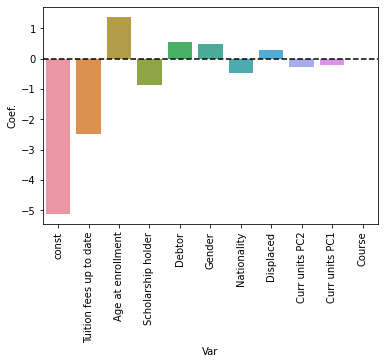

In [11]:
import seaborn as sns

# sort dataframe
fit_df = fit_df.sort_values(by='Coef.', ascending=False, key=abs)

# plot coefficients
g = sns.barplot(data=fit_df, x='Var', y='Coef.')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.axhline(y=0, color='black', linestyle='--')


The constant coefficient is HUGE. This means our predictive model is going to predict false negatives far more often than false positives, which is not what we want. We'll probably have to tune the decision threshold to deal with this.

The most important features are:
1. Tuition fees up to date
2. Age at enrollment
3. Scholarship holder
4. Debtor
5. Nationality
6. Displaced
7. Curr units PC2
8. Curr units PC1

Even though some of these features have small coefficients, that doesn't mean they aren't useful in a predictive model. Even including the non-significant features may improve the model's metrics. This analysis is meant to help us understand which factors are important to examine in the student population. <br>

Given that female is encoded as 0 and male is 1, males are more likely to dropout. This may be because males often aspire for the trades and the military, whereas females have few obvious pathways outside of education that aren't male dominated. This means that preventing male students from dropping out may be a matter of career counseling more so than academic counseling, but more investigation is needed to determine that.<br>
Older individuals are also more likely to dropout. 

### Conclusion 

Tuition fees up to date:<br>
Predictably, those struggling to pay tuition are likely to dropout. This is the single most important factor. 

Age at enrollment:<br>
Older individuals are more likely to dropout.

Scholarship holder:<br>
Students with scholarships are less likely to dropout.

Debtor:<br>
Once again, those with financial struggles are more likely to dropout.

Gender:<br>
Males are more likely to dropout. This may be because males often aspire for the trades and the military, whereas females have few obvious pathways outside of education that aren't male dominated. This means that preventing male students from dropping out may be a matter of career counseling, but more investigation is needed to determine that.

Nationality:<br>
International students are less likely to dropout.

Displaced:<br>
Displaced students are more likely to dropout, though not as much as I'd expect.

Curricular units:<br>
Those with fewer curricular units are more likely to dropout, but not by a lot.

Course:<br>
While course does have an impact on a student's chance of dropping out, it's very small. Course should not be a matter of concern. 